# **Test A/B para Optimización de Ingresos**

## **Introducción**

Este proyecto analiza hipótesis de crecimiento para una tienda online mediante frameworks de priorización (ICE/RICE) y validación experimental con test A/B.

## **Descripción de los Datos**

### **Dataset 1: Priorización de Hipótesis** (`hypotheses_us.csv`)
Contiene hipótesis de crecimiento evaluadas según criterios específicos:

| Campo | Descripción |
|-------|-------------|
| `Hypotheses` | Descripción de cada hipótesis de optimización |
| `Reach` | Alcance potencial de usuarios (escala 1-10) |
| `Impact` | Impacto esperado en usuarios (escala 1-10) |
| `Confidence` | Nivel de confianza en la hipótesis (escala 1-10) |
| `Effort` | Recursos requeridos para implementar (escala 1-10, mayor valor = más recursos) |

### **Dataset 2: Órdenes del Test A/B** (`orders_us.csv`)
Registro de transacciones durante el experimento:

| Campo | Descripción |
|-------|-------------|
| `transactionId` | Identificador único del pedido |
| `visitorId` | Identificador único del usuario |
| `date` | Fecha de la transacción |
| `revenue` | Ingresos generados por el pedido |
| `group` | Grupo experimental (A o B) |

### **Dataset 3: Visitas del Test A/B** (`visits_us.csv`)
Datos agregados de tráfico por grupo y fecha:

| Campo | Descripción |
|-------|-------------|
| `date` | Fecha del registro |
| `group` | Grupo experimental (A o B) |
| `visits` | Número total de visitas |

## **1. Configuración Inicial y Exploración de Datos**

### **1.1 Importación de Librerías**

In [1]:
# Importamos librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import scipy.stats as stats
import datetime as dt

### **1.2 Carga de Datasets**

In [2]:
# Importamos los datos
hypothesis = pd.read_csv('/datasets/hypotheses_us.csv', sep=';',header='infer')
orders = pd.read_csv('/datasets/orders_us.csv', sep=',', header='infer')
visits = pd.read_csv('/datasets/visits_us.csv', sep=',', header='infer')

FileNotFoundError: [Errno 2] No such file or directory: '/datasets/hypotheses_us.csv'

### **1.3 Análisis Exploratorio Inicial**

#### **Exploración del dataset `hypotheses`**

In [ ]:
# Primeras filas del dataset
print(hypothesis.head())

                                          Hypothesis  Reach  Impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   

   Confidence  Effort  
0           8       6  
1           4      10  
2           7       3  
3           3       8  
4           1       1  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+

In [ ]:
# Información general del dataset
print(hypothesis.info())

In [ ]:
# Estandarización de nombres de columnas
hypothesis.columns = hypothesis.columns.str.lower()
print("Columnas estandarizadas:", list(hypothesis.columns))

# Verificación de duplicados
duplicates_count = hypothesis.duplicated().sum()
print(f"Número de filas duplicadas: {duplicates_count}")

0


#### **Exploración del dataset `orders`**

In [ ]:
# Primeras filas del dataset
print(orders.head())

   transactionId   visitorId        date  revenue group
0     3667963787  3312258926  2019-08-15     30.4     B
1     2804400009  3642806036  2019-08-15     15.2     B
2     2961555356  4069496402  2019-08-15     10.2     A
3     3797467345  1196621759  2019-08-15    155.1     B
4     2282983706  2322279887  2019-08-15     40.5     B

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB
None


In [ ]:
# Información general del dataset
print(orders.info()) 

In [ ]:
# Conversión de tipos de datos
orders['date'] = pd.to_datetime(orders['date'])

0


In [ ]:
# Verificación de duplicados
duplicates_count = orders.duplicated().sum()
print(f"Filas duplicadas encontradas: {duplicates_count}")

In [ ]:
# Análisis de integridad de grupos experimentales
print("\n--- Análisis de Contaminación entre Grupos ---")

# Identificar usuarios que aparecen en múltiples grupos
visitor_groups = orders.groupby('visitorId')['group'].nunique()

# Filtrar los usuarios que aparecen en más de un grupo (es decir, en ambos grupos)
visitors_in_both_groups = visitor_groups[visitor_groups > 1]
print(f'Número de usuarios en ambos grupos: {len(visitors_in_both_groups)}')

Número de usuarios en ambos grupos: 58


In [ ]:
if len(visitors_in_both_groups) > 0:
    print("Detectada contaminación entre grupos experimentales")
    
    # Mostrar distribución antes del filtrado
    print("\nDistribución ANTES del filtrado:")
    users_before = orders.groupby('group')['visitorId'].nunique()
    print(users_before)
    
    # Filtrar usuarios contaminados
    orders_filtered = orders[~orders['visitorId'].isin(visitors_in_both_groups.index)]
    
    # Mostrar distribución después del filtrado
    print("\nDistribución DESPUÉS del filtrado:")
    users_after = orders_filtered.groupby('group')['visitorId'].nunique()
    print(users_after)
    
    print(f"\nUsuarios eliminados: {len(visitors_in_both_groups)}")
    print("Dataset limpio para análisis experimental")
    
else:
    print("No hay contaminación entre grupos")
    orders_filtered = orders.copy()

#### **Exploración del dataset `visits`**

In [ ]:
# Primeras filas del dataset
print(visits.head())

         date group  visits
0  2019-08-01     A     719
1  2019-08-02     A     619
2  2019-08-03     A     507
3  2019-08-04     A     717
4  2019-08-05     A     756

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


In [ ]:
# Información general del dataset
print(visits.info())

In [ ]:
# Conversión de tipo de datos
visits['date'] = pd.to_datetime(visits['date'])

# Verificación de duplicados
print(visits.duplicated().sum())

0


## **2. Priorización de Hipótesis**
### **Contexto**
Aplicación de frameworks de priorización (ICE y RICE) para evaluar hipótesis de crecimiento basadas en criterios cuantitativos de impacto, confianza, esfuerzo y alcance.

### **2.1 Framework ICE (Impact × Confidence ÷ Effort)**

In [ ]:
# Calculo del score ICE
hypothesis['ice'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['effort']

# Ranking de hipótesis por ICE
print("=== RANKING ICE ===")
print(hypothesis[['hypothesis','ice']].sort_values(by='ice', ascending=False))

                                          hypothesis        ice
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000


### **2.2 Framework RICE (Reach × Impact × Confidence ÷ Effort)**

In [ ]:
# Cálculo del score RICE
hypothesis['rice'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['effort']

# Ranking de hipótesis por RICE
print("=== RANKING RICE ===")
print(hypothesis[['hypothesis','rice']].sort_values(by='rice', ascending=False))

                                          hypothesis   rice
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2
3  Change the category structure. This will incre...    9.0
1  Launch your own delivery service. This will sh...    4.0
5  Add a customer review page. This will increase...    4.0
4  Change the background color on the main page. ...    3.0


### **2.3 Análisis Comparativo de Frameworks**

In [ ]:
# Comparación directa de ambos rankings
print("=== COMPARACIÓN ICE vs RICE ===")
print(hypothesis[['hypothesis','ice','rice']].sort_values(by='rice',ascending=False))

                                          hypothesis        ice   rice
7  Add a subscription form to all the main pages....  11.200000  112.0
2  Add product recommendation blocks to the store...   7.000000   56.0
0  Add two new channels for attracting traffic. T...  13.333333   40.0
6  Show banners with current offers and sales on ...   8.000000   40.0
8  Launch a promotion that gives users discounts ...  16.200000   16.2
3  Change the category structure. This will incre...   1.125000    9.0
1  Launch your own delivery service. This will sh...   2.000000    4.0
5  Add a customer review page. This will increase...   1.333333    4.0
4  Change the background color on the main page. ...   1.000000    3.0


**Comparación**

In [ ]:
# Análisis de cambios en posicionamiento
ice_rank = hypothesis[['hypothesis', 'ice_score']].sort_values(by='ice_score', ascending=False).reset_index(drop=True)
rice_rank = hypothesis[['hypothesis', 'rice_score']].sort_values(by='rice_score', ascending=False).reset_index(drop=True)

ice_rank['ice_position'] = range(1, len(ice_rank) + 1)
rice_rank['rice_position'] = range(1, len(rice_rank) + 1)

# Merge para ver cambios de posición
position_changes = ice_rank[['hypothesis', 'ice_position']].merge(
    rice_rank[['hypothesis', 'rice_position']], on='hypothesis'
)
position_changes['position_change'] = position_changes['ice_position'] - position_changes['rice_position']

print("\n=== CAMBIOS DE POSICIÓN ===")
print(position_changes.sort_values(by='rice_position'))

### **2.4 Insights y Recomendaciones**
**Diferencias Clave entre ICE y RICE:**

* **ICE** prioriza eficiencia (impacto/esfuerzo) sin considerar escala de usuarios
* **RICE** incorpora el alcance, crucial para productos con gran base de usuarios

**Análisis de Cambios:**

El factor "Reach" en RICE reordena significativamente las prioridades, favoreciendo hipótesis con mayor potencial de alcance de usuarios, aunque requieran mayor esfuerzo relativo.

**Recomendación Estratégica:**

Para una tienda online con volumen significativo de tráfico, **RICE es el framework más apropiado** ya que:
1. Maximiza el impacto total considerando la escala de usuarios
2. Equilibra mejor el retorno de inversión real
3. Prioriza iniciativas con mayor potencial de crecimiento absoluto

**Hipótesis Prioritaria:**
Add a subscription form to all the main pages...

## **3. Análisis del test A/B**

### **3.1 Preparación: Recopilación de Datos Acumulados**

#### **3.1.1 Creación de matriz fecha-grupo**

In [ ]:
# Generación de combinaciones únicas fecha-grupo para análisis acumulativo
datesGroups = orders_filtered[['date','group']].drop_duplicates()
print(datesGroups)

           date group
0    2019-08-15     B
7    2019-08-15     A
45   2019-08-16     A
47   2019-08-16     B
55   2019-08-01     A
...         ...   ...
1068 2019-08-12     A
1114 2019-08-13     B
1116 2019-08-13     A
1149 2019-08-14     B
1150 2019-08-14     A

[62 rows x 2 columns]


**3.1.2 Recopilación de datos diarios acumulados agregados sobre los pedidos.**

In [ ]:
# Cálculo de métricas acumuladas de pedidos por fecha y grupo
# Permite visualizar la evolución temporal del experimento
ordersAggregated = datesGroups.apply(
    lambda x: orders_filtered[  # Para cada combinación fecha-grupo, filtra los pedidos acumulados hasta esa fecha para ese grupo
        np.logical_and(
            orders_filtered['date'] <= x['date'],  # Mantiene pedidos hasta la fecha actual (acumulados)
            orders_filtered['group'] == x['group']  # Solo los pedidos del grupo actual (A o B)
        )
    ].agg(
        {                                           # Resume los datos filtrados acumulados en 5 métricas
            'date': 'max',                          # Última fecha
            'group': 'max',                         # Grupo (A o B)
            'transactionId': pd.Series.nunique,     # Pedidos únicos acumulados
            'visitorId': pd.Series.nunique,         # Usuarios únicos acumulados
            'revenue': 'sum'                        # Ingresos acumulados
        }
    ),
    axis=1                                          # Se aplica fila por fila
).sort_values(by=['date', 'group'])                 # Ordena para que las fechas y grupos estén bien organizados

# Muestra las primeras filas para validar el resultado
print(ordersAggregated.head())

          date group  transactionId  visitorId  revenue
55  2019-08-01     A             23         19   2266.6
66  2019-08-01     B             17         17    967.2
175 2019-08-02     A             42         36   3734.9
173 2019-08-02     B             40         39   3535.3
291 2019-08-03     A             66         60   5550.1


*Interpretación: Es como si hubiéramos estado calculando los resultados de nuestra prueba todos los días hasta la fecha actual, almacenándolos en las filas de la tabla ordersAggregated.*

**3.1.3 Recopilación de datos diarios acumulados agregados sobre los visitantes.**

In [ ]:
# Cálculo de visitas acumuladas para análisis de conversión
# Permite visualizar la evolución de visitantes únicos por fecha y grupo
visitsAggregated = datesGroups.apply(
    lambda x: visits[
        # Filtro: conserva filas hasta la fecha actual y solo del grupo actual
        np.logical_and(
            visits['date'] <= x['date'],  # Fechas hasta la fecha actual
            visits['group'] == x['group']  # Solo el grupo A o B según corresponda
        )
    ].agg(
        {  # Calcula métricas acumuladas
            'date': 'max',          # Fecha máxima (actual)
            'group': 'max',         # Grupo (A o B)
            'visits': 'sum'         # Total acumulado de visitantes hasta la fecha
        }
    ),
    axis=1  # Aplica la función fila por fila (cada fila es una fecha-grupo)
).sort_values(by=['date', 'group'])  # Ordena el DataFrame final

# Muestra las primeras filas para validar el resultado
print(visitsAggregated.head())

          date group  visits
55  2019-08-01     A     719
66  2019-08-01     B     713
175 2019-08-02     A    1338
173 2019-08-02     B    1294
291 2019-08-03     A    1845


**3.1.4 Fusionamos las dos tablas**

In [ ]:
# Fusionamos las dos tablas para obtener un DataFrame acumulativo final
cumulativeData = ordersAggregated.merge(visitsAggregated, left_on=['date','group'], right_on=['date','group'])
# Convertimos los nombres de las columnas para mayor claridad
cumulativeData.columns = ['date','group','orders','buyers','revenue','visitors']

print(cumulativeData)

         date group  orders  buyers  revenue  visitors
0  2019-08-01     A      23      19   2266.6       719
1  2019-08-01     B      17      17    967.2       713
2  2019-08-02     A      42      36   3734.9      1338
3  2019-08-02     B      40      39   3535.3      1294
4  2019-08-03     A      66      60   5550.1      1845
..        ...   ...     ...     ...      ...       ...
57 2019-08-29     B     510     490  74576.7     17708
58 2019-08-30     A     460     437  52363.7     18037
59 2019-08-30     B     531     511  77863.5     18198
60 2019-08-31     A     468     445  53212.0     18736
61 2019-08-31     B     548     528  79651.2     18916

[62 rows x 6 columns]


In [ ]:
# Validación de integridad de datos
print(f"\nGrupos experimentales: {cumulativeData['group'].unique()}")
print(f"Período de análisis: {cumulativeData['date'].min()} - {cumulativeData['date'].max()}")

### **3.2 Representación gráfica del ingreso acumulado por grupo.**

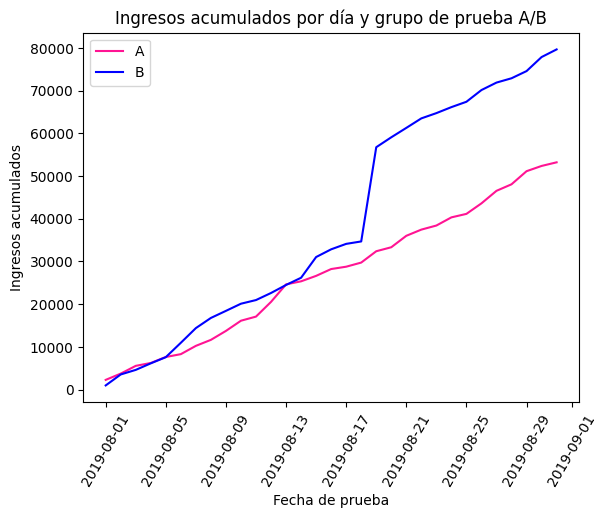

In [ ]:
# DataFrame con pedidos e ingresos acumulados por día, grupo A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue','orders']]
# DataFrame con pedidos e ingresos acumulados por día, grupo B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue','orders']]

# Gráfico de ingresos acumulados del grupo A
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A', color='deeppink')
# Gráfico de ingresos acumulados del grupo B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B', color='blue')

# Personalización del gráfico
plt.title('Ingresos acumulados por día y grupo de prueba A/B')
plt.xlabel('Fecha de prueba')
plt.ylabel('Ingresos acumulados')
plt.tick_params(axis='x', rotation=60)
plt.legend()
plt.show()

**Análisis:**

* Ambos grupos muestran una tendencia/crecimiento sostenido de ingresos acumulados a lo largo del periodo.
* El grupo B demuestra un desempeño superior, alcanzando aproximadamente $78,000 en ingresos acumulados vs. $54,000 del grupo A (diferencia del ~44%).
* El grupo B presenta aceleraciones pronunciadas en ciertos periodos, sugiriendo eventos de compra de alto valor o incrementos significativos en la frecuencia de pedido.
* El grupo B muestra cambios de pendiente notable alrededor de las fechas 2019-08-13 y 2019-08-17, lo que podría indicar:
   - Pedidos de alto valor (outliers)
   - Mejoras en la conversión de usuarios de alto valor
   - Efectos estacionales o promocionales

En general, el grupo B parece generar mayor valor por usuario, sin embargo, es fundamental realizar un análisis adicional en el tamaño promedio de pedido y detectar cualquier anomalía para confirmar la significancia estadística.




Los ingresos aumentan constantemente durante toda la prueba. Sin embargo, el grupo B tiene picos en los ingresos en ciertos puntos, así como el grupo A pero en menor cantidad. Esto puede implicar un aumento en el número de pedidos o la existencia de pedidos muy caros en la muestra.

### **3.2 Representación gráfica del tamaño de pedido promedio acumulado por grupo.**

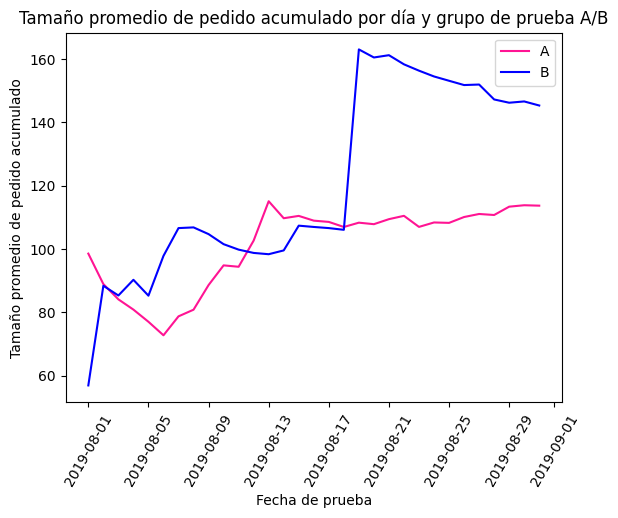

In [ ]:
# Grafico de tamaño promedio de pedido acumulado del grupo A
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A', color='deeppink')
# Grafico de tamaño promedio de pedido acumulado del grupo B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B', color='blue')

# Personalización de gráfico
plt.title('Tamaño promedio de pedido acumulado por día y grupo de prueba A/B')
plt.xlabel('Fecha de prueba')
plt.ylabel('Tamaño promedio de pedido acumulado')
plt.tick_params(axis='x', rotation=60)
plt.legend()
plt.show()

**Análisis**

Los datos revelan patrones contrastantes entre grupos que explican las diferencias observadas en ingresos acumulados. El grupo B experimenta un incremento significativo en el tamaño promedio de pedido, alcanzando un máximo de $162 aproximadamente, alrededor del 17 de agosto, antes de estabilizarse cerca de $145.

El grupo A mantiene mayor consistencia, con valores entre $110-115 a lo largo del experimento. Esta estabilidad corrobora el crecimiento lineal observado en sus ingresos acumulados.

Un hallazo crítico es la tendencia descendiente del grpo B hacia el final del periodo experimental. Esta volatilidad sugiere la presencia de outliers o efectos temporales que requieren validación estadística. El comportamiento del grupo A, aunque genera menor valor absoluto, demuestra mayor predictibilidad.

Dicho esto, se requiere realizar un análisis más puntual para la detección de anomalías significativas.

### **3.3 Representación gráfica de la diferencia relativa en el tamaño de pedido promedio acumulado B vs A**

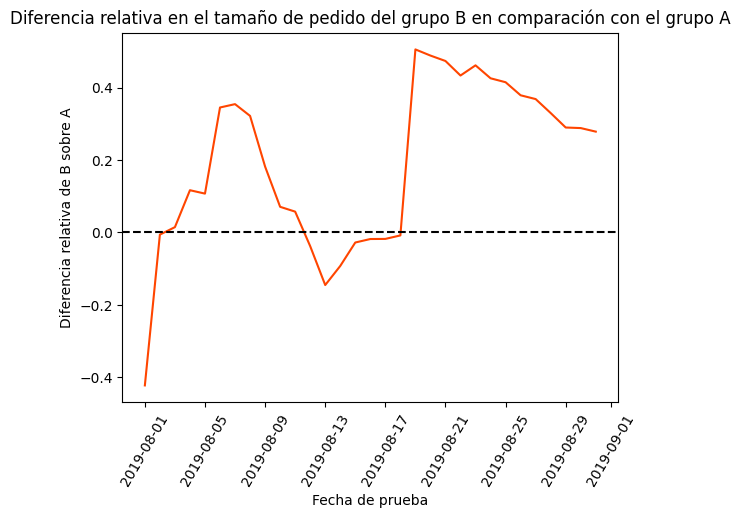

In [ ]:
# Unimos los datos acumulados en un DataFrame
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A','B'])

# Trazamos un gráfico de diferencia relativa para los tamaños promedio de compra
plt.plot(mergedCumulativeRevenue['date'],
        (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1, 
         color='orangered')

# Personalización de gráfico
plt.title('Diferencia relativa en el tamaño de pedido del grupo B en comparación con el grupo A')
plt.xlabel('Fecha de prueba')
plt.ylabel('Diferencia relativa de B sobre A')
plt.tick_params(axis='x', rotation=60)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

**Análisis**

El gráfico evidencia la superioridad del grupo B durante la mayor parte del experimento, con diferencias relativas que alcanzan hasta 50% en ciertos períodos. Particularmente notable es el incremento sostenido posterior al 17 de agosto, donde el grupo B mantiene consistentemente entre 25-45% de ventaja sobre el grupo A.

La volatilidad inicial y los picos pronunciados confirman la hipótesis de presencia de outliers significativos. El comportamiento errático en las primeras fechas, incluyendo períodos donde B underperforma (-40%), sugiere que valores extremos están influenciando desproporcionadamente las métricas agregadas.

Aunque los resultados favorecen al grupo B, la magnitud de las fluctuaciones indica que el tamaño promedio de pedido puede estar siendo distorsionado por transacciones atípicas. La tendencia descendente hacia el final del período (de 50% a 28%) refuerza esta preocupación, sugiriendo que el efecto inicial podría no ser representativo del comportamiento típico del usuario.

### **3.4 Tasa de conversión de cada grupo**

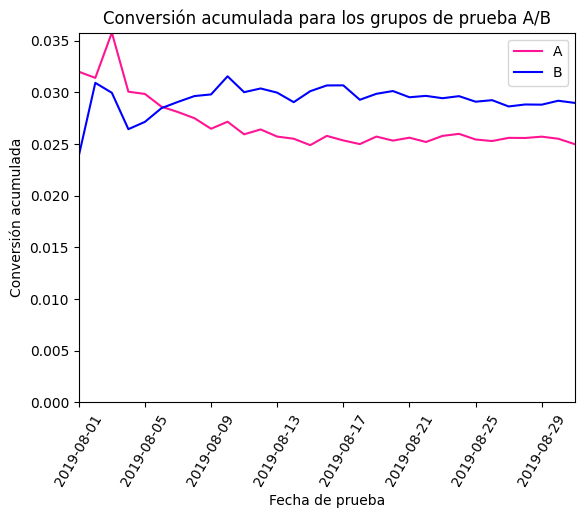

In [63]:
# Calculamos la conversión acumulada
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# Seleccionamos los datos en el grupo 
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
# Seleccionamos los datos en el grupo B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# Trazamos los gráficos
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A', color='deeppink')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B', color='blue')

# Establecemos la escala de los ejes
plt.axis([cumulativeData['date'].min(), cumulativeData['date'].max(), 0, cumulativeData['conversion'].max()])

# Personalización de gráfico
plt.title('Conversión acumulada para los grupos de prueba A/B')
plt.xlabel('Fecha de prueba')
plt.ylabel('Conversión acumulada')
plt.tick_params(axis='x', rotation=60)
plt.legend()
plt.show()

**Análisis**

Los grupos fluctuaron al rededor de la primera semana con un pico positivo, sin embargo, durante el tiempo de la prueba, el grupo B se mantuvo constante con tendencia positiva (tuvo mayor tasa de conversión) en comparación con el grupo A. Cabe destacar que no hemos hecho un análisis o filtro de valores atípicos, lo que podría estarnos arrojando resultados erróneos.

El análisis de conversión revela un patrón diferente al observado en las métricas de ingresos. Ambos grupos muestran tasas de conversión similares, con el grupo B manteniendo una ligera ventaja sostenida de aproximadamente 0.5 puntos porcentuales (3.0% vs 2.5%).

Tras la volatilidad inicial de la primera semana, ambos grupos convergen hacia tasas de conversión estables. El grupo B se estabiliza alrededor del 3.0%, mientras que el grupo A se mantiene cerca del 2.5%. Esta diferencia del 20% relativo en conversión es consistente a lo largo del experimento.

Los resultados sugieren que **la ventaja del grupo B en ingresos no proviene únicamente de mayor conversión, sino de la combinación de mejor tasa de conversión y mayor valor por transacción.** Esta dualidad indica que la variante B optimiza tanto la adquisición de usuarios como su valor monetario.

La estabilidad de ambas métricas post-período inicial sugiere que los cambios observados representan efectos genuinos del experimento, reduciendo la probabilidad de que sean únicamente resultado de fluctuaciones aleatorias.


### **3.5 Gráfico de dispersión del número de pedidos por usuario.**

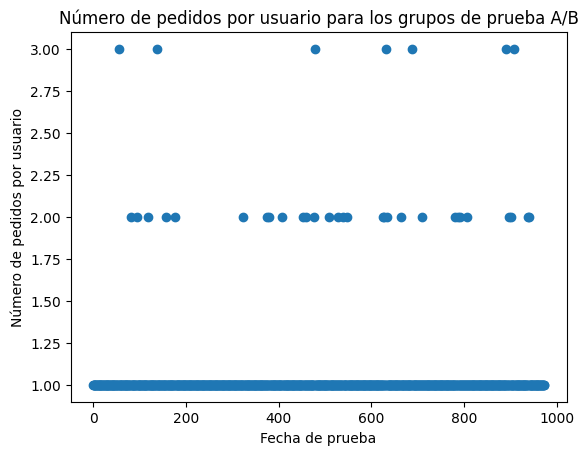

In [64]:
# Agrupamos para graficar
ordersByUsers = (
    orders_filtered.groupby('visitorId', as_index=False).agg({'transactionId':pd.Series.nunique})
)
ordersByUsers.columns = ['userId', 'orders']

# Graficamos
x_values = pd.Series(range(0,len(ordersByUsers))) # Rango de valores en x
plt.scatter(x_values, ordersByUsers['orders']) 

# Personalización de gráfico
plt.title('Número de pedidos por usuario para los grupos de prueba A/B')
plt.xlabel('Fecha de prueba')
plt.ylabel('Número de pedidos por usuario')
plt.show()

**Análisis**

Hay muy pocos usuarios que tienen más de 2 pedidos (podríamos considerarlos valores atípicos) y muy probablemente haya que ajustar o filtrar los datos en donde los pedidos sean igual o menores a 2.

### **3.6 Percentiles del número de pedidos por usuario.**


In [25]:
# Percentiles 95 y 99 del número de pedidos por usuario
print(np.percentile(ordersByUsers['orders'],[95,99]))

[1. 2.]


**Conclusión**

El análisis de pedidos revela que el 95% de los usuarios realizaron un pedido o menos, mientras que solo el 5% realizaron más de un pedido. Además, el 99% de los usuarios realizaron dos pedidos o menos, con apenas un 1% superando este umbral.

Dado este comportamiento, **se recomienda establecer un límite superior de 1 pedido por usuario como referencia para la actividad habitual.** Este umbral puede servir como criterio para la detección y filtrado de posibles anomalías en el patrón de compra.

### **3.7 Gráfico de dispersión de los precios de los pedidos.**

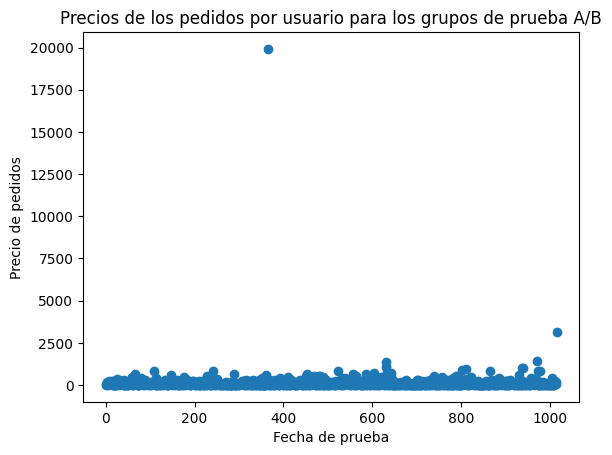

In [66]:
# Graficamos la dispersión de los precios d elos pedidos
x_values = pd.Series(range(0, len(orders_filtered['revenue']))) # Rango de valores en x
plt.scatter(x_values, orders_filtered['revenue'])

# Personalización de gráfico
plt.title('Precios de los pedidos por usuario para los grupos de prueba A/B')
plt.xlabel('Fecha de prueba')
plt.ylabel('Precio de pedidos')
plt.show()

**Análisis**

A primera vista, se identifican dos pedidos significativamente grandes en comparación con el resto, lo que podría estar generando ruido en las visualizaciones. 

Este comportamiento atípico puede distorsionar la interpretación de los datos, por lo que es recomendable evaluar su impacto y considerar estrategias para su tratamiento en el análisis.

### **3.8 Percentiles de los precios de los pedidos.**

In [27]:
# Percentil 95 y 99 para los precios de los pedidos por usuario
print(np.percentile(orders_filtered['revenue'], [95,99]))

[414.275 830.3  ]


**Conclusión**

El análisis de pedidos muestra que el 95% de los usuarios realizaron compras de 414.275 o menos, mientras que solo el 5% superaron este valor. Además, el 99% de los usuarios realizaron pedidos de 830.3 o menos, dejando únicamente un 1% con montos superiores.

Con base en este comportamiento, **se recomienda establecer 414.275 como umbral superior para definir un patrón de compra habitual.** Este límite puede utilizarse como criterio para identificar y filtrar posibles anomalías en los datos.

### **3.9 Significancia estadística de la diferencia en la conversión entre los grupos utilizando datos en bruto.**

In [28]:
# Almacenaremos los usuarios con al menos un pedido e indicaremos el número de pedidos realizados
ordersByUsersA = orders_filtered[orders_filtered['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId':pd.Series.nunique})
ordersByUsersA.columns = ['userId','orders']

ordersByUsersB = orders_filtered[orders_filtered['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId':pd.Series.nunique})
ordersByUsersB.columns = ['userId','orders']

In [77]:
# Declaramos las variables con usuarios de diferentes grupos y números de pedidos
sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum()-len(ordersByUsersA['orders'])), name='orders')], axis=0)
sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum()-len(ordersByUsersB['orders'])), name='orders')], axis=0)

print('p-value:')
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])) # valor p del test estadístico Mann-Whitney U

print('\nDiferencia relativa en la conversión del grupo B sobre el grupo A:')
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1)) # Esta línea calcula el aumento relativo del grupo B en comparación con el grupo A.

p-value:
0.011

Diferencia en la conversión del grupo B sobre el grupo A:
0.160


**Conclusión**

El valor p obtenido (0.011) es menor que 0.05, lo que indica que la diferencia en la conversión entre los grupos es estadísticamente significativa. Por lo tanto, se rechaza la hipótesis nula en favor de la hipótesis alternativa.

Además, el grupo B mostró un incremento relativo del 16% en comparación con el grupo A, lo que sugiere un mejor rendimiento en términos de conversión.

### **3.10 Significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando datos en bruto.**

In [ ]:
# Imprimimos el valor de p
print('p-value')
print("{0:.3f}".format(stats.mannwhitneyu(orders_filtered[orders_filtered['group']=='A']['revenue'], orders_filtered[orders_filtered['group']=='B']['revenue'])[1]))
# Imprimimos el aumento relativo del grupo B en comparación con el grupo A
print('\nDiferencia relativa en el tamaño promedio de pedido del grupo B sobre el grupo A')
print("{0:.3f}".format(orders_filtered[orders_filtered['group']=='B']['revenue'].mean()/orders_filtered[orders_filtered['group']=='A']['revenue'].mean()-1))

p-value
0.862

Diferencia relativa en el tamaño promedio de pedido del grupo B sobre el grupo A
0.278


**Conclusión**

Dado que el valor p obtenido (0.862) es considerablemente mayor que 0.05, no se rechaza la hipótesis nula, lo que indica que no hay evidencia estadística suficiente para afirmar que el tamaño promedio de los pedidos difiere entre los grupos.

Sin embargo, se observa que el tamaño promedio de pedido en el grupo B es mayor en comparación con el grupo A, aunque esta diferencia no es estadísticamente significativa.

### **3.11 Significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados.**

Para el análisis, definiremos usuarios anómalos como aquellos que han realizado más de un pedido o un pedido superior a 500. De este modo, excluiremos:
- El 5% de los usuarios con mayor número de pedidos.
- Entre el 1% y el 5% de los usuarios con los pedidos más caros.
A continuación, generaremos subconjuntos de datos:
- usersWithManyOrders: Usuarios que realizaron más de un pedido.
- usersWithExpensiveOrders: Usuarios cuyos pedidos superan los 500.
Finalmente, uniremos ambos subconjuntos en una tabla denominada abnormalUsers para su posterior análisis.

In [31]:
# Obtenemos a los usuarios con más de 1 orden
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders']>1]['userId'], ordersByUsersB[ordersByUsersB['orders']>1]['userId']], axis=0)
# Obrenemos a los usuarios con órdenes mayores a $500
usersWithExpensiveOrders = orders_filtered[orders_filtered['revenue']>500]['visitorId']
# Juntamos los dataframes 
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values()

print(abnormalUsers.head())
print(abnormalUsers.shape)

568     113298937
1099    148427295
461     154576532
928     204675465
33      249864742
dtype: int64
(63,)


**Conclusión**

En total, tenemos 63 usuarios anómalos. Tratemos de averiguar cómo sus acciones afectaron los resultados de la prueba

#### **3.11.1 Análisis de Usuarios anómalos**

In [32]:
# Prepararemos muestras del número de pedidos por usuario para cada grupo de prueba
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)

In [78]:
# Aplicamos el criterio estadístico de Mann-Whitney a las muestras
print('p-value:')
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

print('Diferencia relativa en la conversión del grupo B sobre el grupo A:')
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value:
0.016
Diferencia en la conversión del grupo B sobre el grupo A:
0.176


El nuevo análisis arroja un valor p de 0.016, comparado con el valor previo de 0.011. Dado que sigue siendo menor que 0.05, se rechaza la hipótesis nula, lo que confirma que existe una diferencia estadísticamente significativa en la conversión entre los grupos.

Además, se observa que el grupo B presentó un incremento relativo del 17% en comparación con el grupo A, manteniéndose prácticamente igual respecto al análisis anterior.

### **3.12 Significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados.**

In [76]:
# Muestra el valor p calculado con la prueba U de Mann-Whitney
print('p-value:')
print("{0:.3f}".format(stats.mannwhitneyu(
    orders_filtered[np.logical_and(
        orders_filtered['group']=='A', # Selecciona datos en el grupo A
        np.logical_not(orders_filtered['visitorId'].isin(abnormalUsers)))]['revenue'],
    orders_filtered[np.logical_and(
        orders_filtered['group']=='B', # Selecciona datos en el grupo B
        np.logical_not(orders_filtered['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))

# Muestra la diferencia relativa en el ingreso medio entre los grupos B y A
print('Diferencia relativa en el tamaño promedio de pedido del grupo B sobre el grupo A:')
print("{0:.3f}".format(
    orders_filtered[np.logical_and(orders_filtered['group']=='B', # Selecciona datos en el grupo B
                    np.logical_not(orders_filtered['visitorId'].isin(abnormalUsers)))]['revenue'].mean()/ # Calcula el ingreso medio para el grupo B
    orders_filtered[np.logical_and(orders_filtered['group']=='A', # Selecciona datos en el grupo A
                    np.logical_not(orders_filtered['visitorId'].isin(abnormalUsers)))]['revenue'].mean()-1)) # Calcula el ingreso medio para el grupo A

p-value:
0.575
Diferencia relativa en el tamaño promedio de pedido del grupo B sobre el grupo A;
-0.070


El valor p ha disminuido ligeramente, pero sigue siendo mayor que 0.05, lo que indica que no hay evidencia estadística suficiente para afirmar una diferencia significativa en el tamaño promedio de pedido entre los grupos.

Sin embargo, tras filtrar los valores atípicos, la diferencia en el tamaño promedio de compra del grupo B se redujo al 7%, comparado con el 27% obtenido previamente, lo que sugiere un impacto relevante de los datos extremos en el análisis inicial.

## **4. Resumen**  

A continuación, se presentan los valores obtenidos **antes y después** de filtrar los valores atípicos:  

### **Antes**  
**Conversión:**  
- **p-value:** 0.011 (**<0.05**, la diferencia entre las conversiones es estadísticamente significativa.)  
- **Diferencia en la conversión B sobre A:** 16% (La conversión en el grupo B fue **un 16% mayor** que en el grupo A.)  

**Tamaño promedio de compra:**  
- **p-value:** 0.862 (**NO** hay evidencia estadística suficiente para afirmar que el tamaño promedio del pedido sea diferente entre A y B.)  
- **Diferencia en tamaño promedio de pedido B sobre A:** 27% (Aunque el tamaño promedio en B parece ser **27.8% mayor**, la evidencia estadística **no respalda esta diferencia**.)  

### **Después**  
**Conversión:**  
- **p-value:** 0.016 (**significativo**)  
- **Diferencia en la conversión B sobre A:** 17%  

**Tamaño promedio de compra:**  
- **p-value:** 0.575 (**NO** hay evidencia estadística suficiente para afirmar que el tamaño promedio del pedido es diferente entre A y B.)  
- **Diferencia en tamaño promedio de pedido B sobre A:** -7%  

### **Análisis Final**  

Antes del filtrado, el **grupo B mostró una conversión significativamente mayor** (+16% vs grupo A). Sin embargo, **no hubo evidencia estadística** de que el tamaño promedio del pedido fuera diferente entre los grupos.  

Después de filtrar los valores atípicos, la **conversión del grupo B se mantuvo ligeramente mayor** (+17%), pero el **tamaño promedio de pedido disminuyó**, siendo **un 7% menor** que en el grupo A (**sin significancia estadística**).  

### **Interpretación**  
Esto implica que **el aumento en conversión del grupo B no está impulsado por pedidos más grandes**, sino por **una mayor cantidad de pedidos**. En otras palabras, **el grupo B genera más ventas, pero no necesariamente por pedidos de mayor tamaño**.  

Por lo tanto, **el incremento en ingresos dependerá del volumen de conversiones**, no del tamaño de los pedidos.  

## **5. Toma de decisión basada en los resultados**

Tras analizar los resultados, se consideran las siguientes opciones:
- Parar la prueba y considerar a uno de los grupos como líder.
- Parar la prueba y concluir que no hay diferencia entre los grupos.
- Continuar la prueba.

**Se decide parar la prueba y considerar al grupo B como el grupo ganador.**

A pesar de haber aplicado un filtrado para eliminar valores atípicos, el grupo B mantuvo un aumento en la conversión, confirmando la tendencia observada en las visualizaciones. El comportamiento constante del grupo B, con una conversión mayor en comparación con el grupo A, valida la decisión de establecerlo como el grupo óptimo para futuros análisis y estrategias.